In [2]:
#datasci libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#tensorflow
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam, RMSprop

#visualization
from matplotlib.pyplot import imshow
import cv2

#misc
import os.path
from pathlib import Path
import glob
import random
from sklearn.metrics import classification_report

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [12]:
model = load_model('inceptionv3_birdclassifier.h5', compile = False)
model.compile(optimizer = Adam(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [5]:
train_path = 'C:\\DeepLearning\\birdclassificationproject\\birds\\train'
val_path = 'C:\\DeepLearning\\birdclassificationproject\\birds\\valid'
test_path = 'C:\\DeepLearning\\birdclassificationproject\\birds\\test'

batch = 32
imgres = (224, 224)

In [6]:
image_dir = Path('C:\\DeepLearning\\birdclassificationproject\\birds\\train')

filepaths = list(image_dir.glob(r'**/*.JPG'))  + list(image_dir.glob(r'**/*.png')) 

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)
print(image_df.shape)
image_df.head()

(84635, 2)


Filepath            Label
0  C:\DeepLearning\birdclassificationproject\bird...  ABBOTTS BABBLER
1  C:\DeepLearning\birdclassificationproject\bird...  ABBOTTS BABBLER
2  C:\DeepLearning\birdclassificationproject\bird...  ABBOTTS BABBLER
3  C:\DeepLearning\birdclassificationproject\bird...  ABBOTTS BABBLER
4  C:\DeepLearning\birdclassificationproject\bird...  ABBOTTS BABBLER

In [7]:
train_generator = ImageDataGenerator(rescale = 1./255)
val_generator = ImageDataGenerator(rescale = 1./255)
test_generator = ImageDataGenerator(rescale = 1./255)

train_images = train_generator.flow_from_directory(
    train_path,
    target_size=imgres,
    class_mode='categorical',
    batch_size=batch
)

val_images = val_generator.flow_from_directory(
    val_path,
    target_size=imgres,
    class_mode='categorical',
    batch_size=batch
)

test_images = test_generator.flow_from_directory(
    test_path,
    target_size=imgres,
    class_mode='categorical',
    batch_size=batch,
    shuffle = False
)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [8]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.19486
Test Accuracy: 97.07%


2/2 [==============================] - 0s 299ms/step


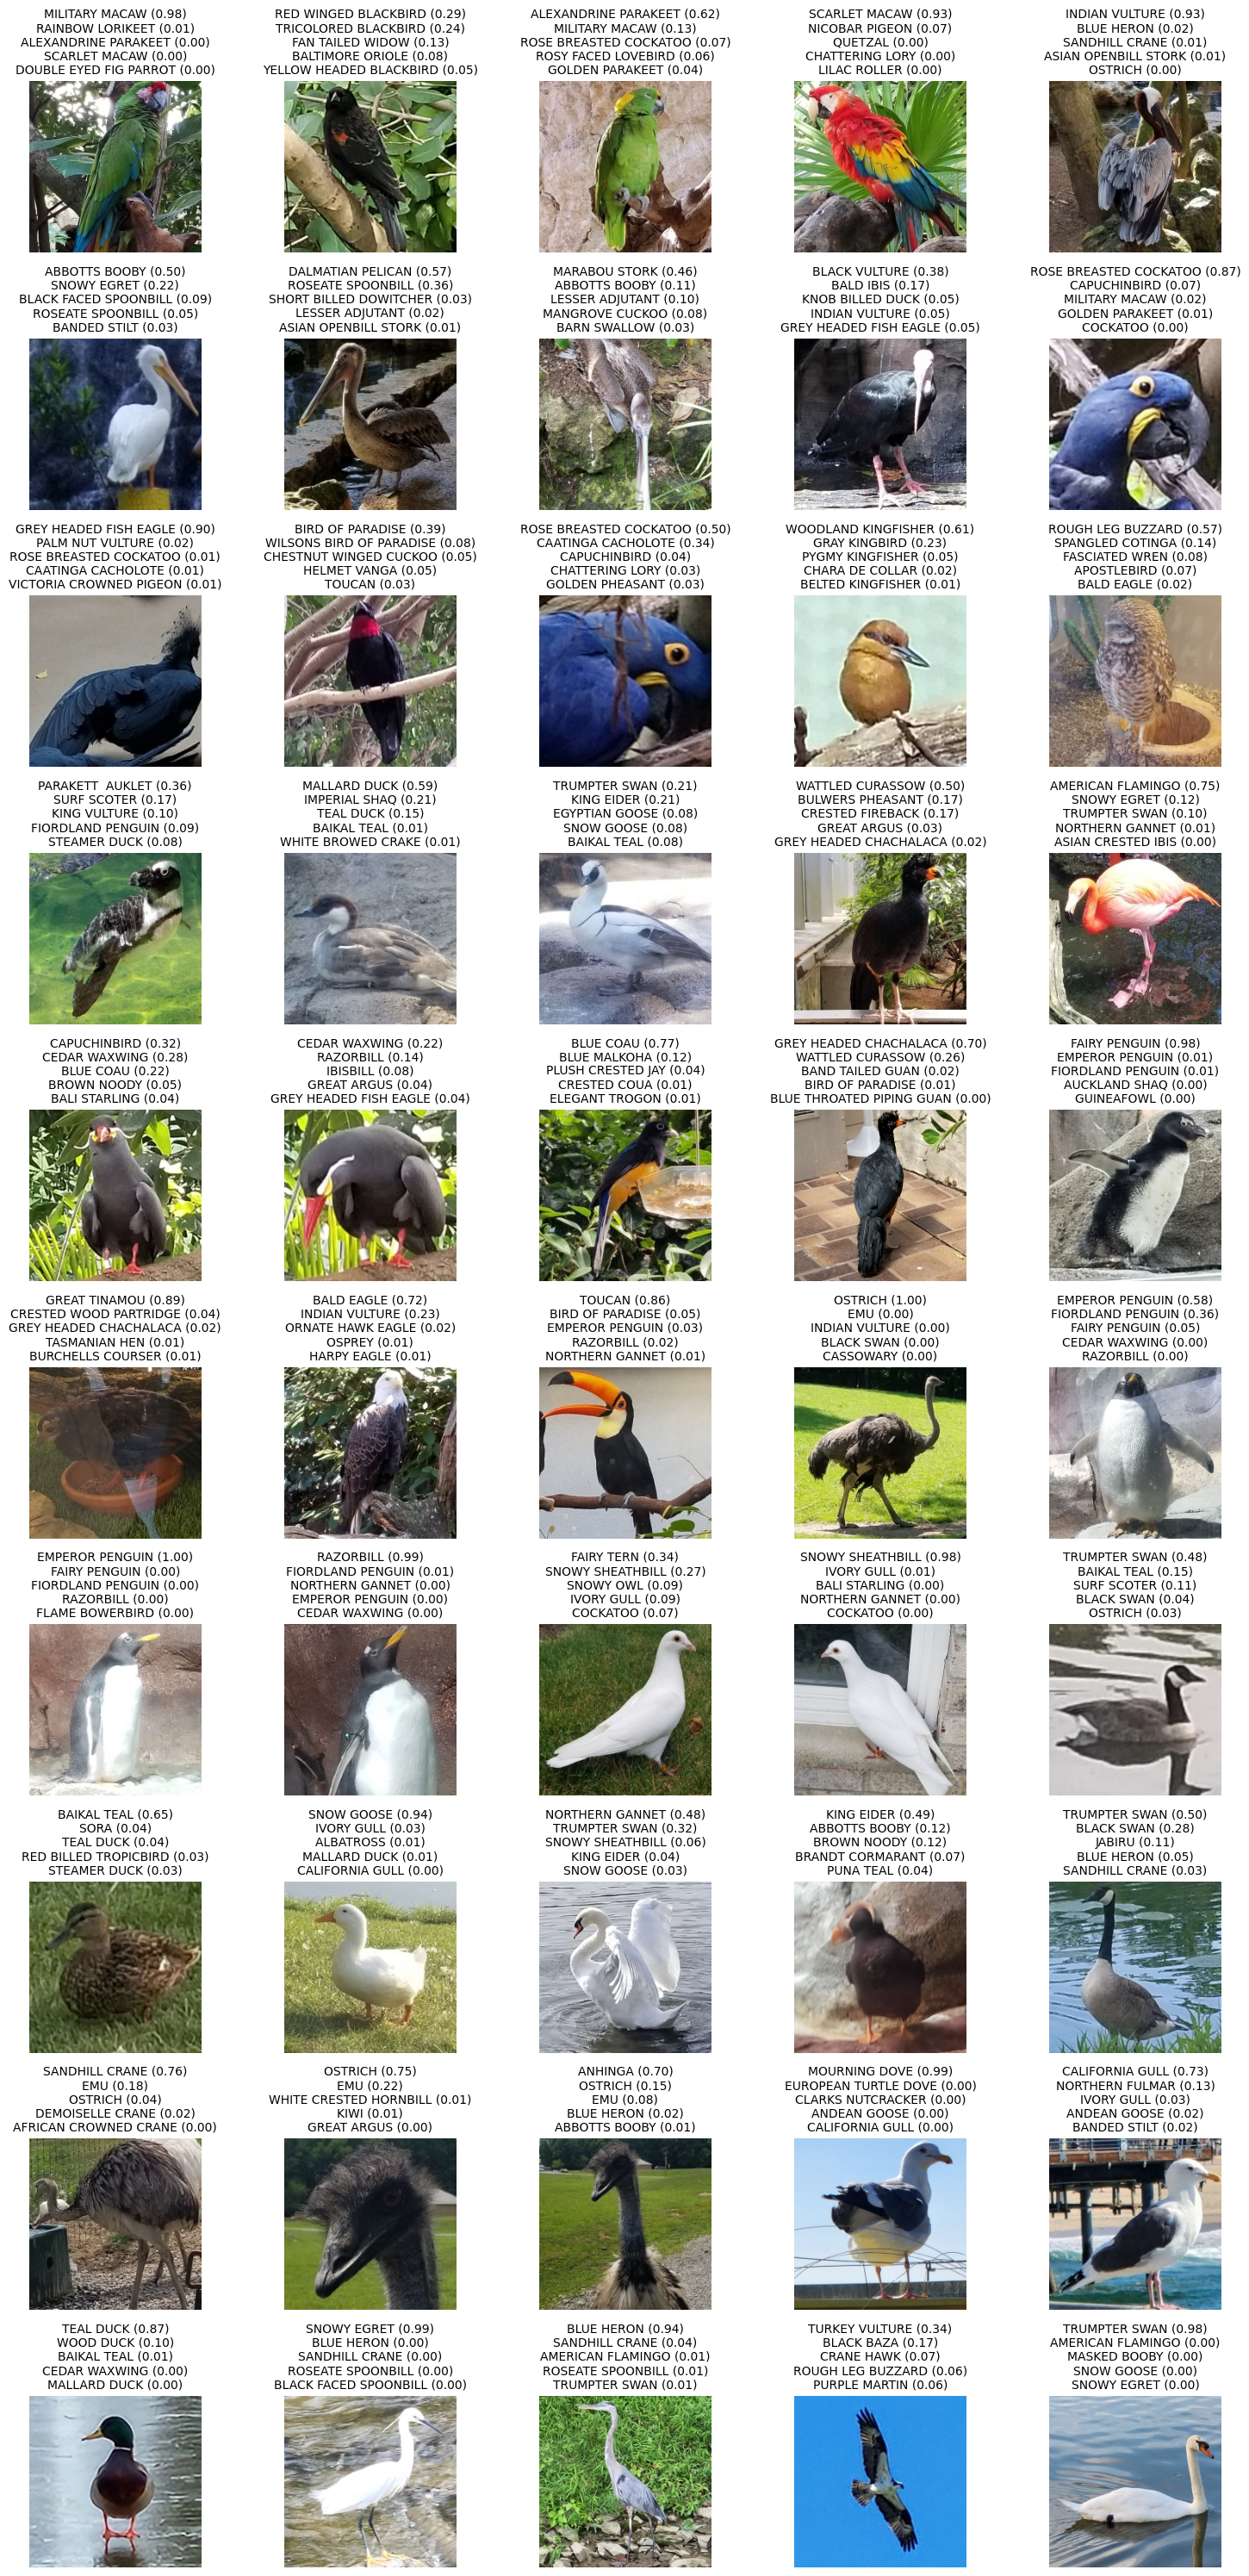

In [45]:
mybirds_path = 'C:\\DeepLearning\\birdclassificationproject\\mybirdsresized'
preprocessed_images = []
for filename in os.listdir(mybirds_path):
    if filename.lower().endswith(('.jpg')):
        image_path = os.path.join(mybirds_path, filename)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (224, 224))
        image = image / 255.0  # Normalize to [0, 1]
        image = np.array(image, dtype=np.float32)
        preprocessed_images.append(image)
predictions = model.predict(np.array(preprocessed_images))
num_rows = 10
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 30))
for i, filename in enumerate(os.listdir(mybirds_path)):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        top_classes = np.argsort(predictions[i])[-5:][::-1]
        top_probabilities = predictions[i][top_classes]
        image = cv2.imread(os.path.join(mybirds_path, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(image)
        ax.axis('off')
        
        # Create the title using class labels and probabilities
        title = []
        for j, (class_idx, probability) in enumerate(zip(top_classes, top_probabilities)):
            title.append(f"{image_df['Label'].unique()[class_idx]} ({probability:.2f})")
        
        ax.set_title('\n'.join(title), fontsize=10)

plt.tight_layout()
plt.show()

Great performance: military macaw, scarlet macaw, american flamingo, bald eagle, toucan, ostrich, snow goose, california gull, snowy egret, blue heron, trumpeter swan, great tinamou, I'll count emperor and fairy penguin since the actual species isn't in the dataset

Unexplainable misclassifications:  rose breasted cockatoo (should be hyacinth macaw, no idea why it isn't), baikal teal (very clearly a mallard teal), grey headed chachalaca (wattled curassow has pretty distinct features, somehow correctly identified later), ostrich/anhinga (very obviously an emu)

Understandable misclassifications: indian vulture (pelican but bad angle), marabou stork (spoonbill but very bad angle), black vulture (ibis but unclear image), blue coau (don't know what this is), razorbill (penguin but bad crop?), teal duck (should be mallard duck), mourning dove (should be california gull but coloring is gray from shade, not white), grey headed fish eagle (shape is similar but idk what it is),  king eider (puffin but blurry?), sandhill crane (2 birds in the image), capuchinbird/waxwing (inca tern's mustache is super distinct but distracting backgrounds), northern gannet (the swan was doing a weird pose), turkey vulture (disappointing that it didn't recognize an osprey but it's kind of far I guess)

Not in dataset: canada goose, that white racing pigeon, african penguin, desert owl?

Why did my model do much worse on bird pictures from my phone vs bird pictures from the test set? I'm almost certain it's because the pictures in the dataset I used had blurred backgrounds while the pictures from my phone did not. This caused the model to confuse background details for bird features, reducing performance unless the bird's features were super obvious (flamingo, macaw, toucan, etc...) Also a lot of my images were from bad angles, or I had to do weird crops because of objects or other birds in the way. Overall, just another fun way to evaluate my model using real-world data.